In [26]:
import pandas as pd 
import numpy as np  

## for plotting
import matplotlib.pyplot as plt 
import seaborn as sns  


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.3/102.3 kB 1.7 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [27]:
import folium
from folium import plugins
import plotly.express as px

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 kB 1.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 2.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 4.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.6/18.6 MB 2.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 2.6 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [28]:
## for simple routing
import osmnx as ox
import networkx as nx 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 2.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.2/37.2 MB 6.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3

[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [29]:
## for advanced routing 
from ortools.constraint_solver import pywrapcp  #9.6
from ortools.constraint_solver import routing_enums_pb2

In [30]:
city = "Hong Kong"

dtf = pd.read_csv('/Users/nishthapandey/Downloads/directory.csv')
dtf = dtf[dtf["City"]==city][
        ["City","Street Address","Latitude","Longitude"]
      ].reset_index(drop=True)
dtf = dtf.reset_index().rename(
      columns={"index":"id", "Latitude":"y", "Longitude":"x"})

print("tot:", len(dtf))
dtf.head(3)

tot: 104


,id,City,Street Address,y,x
0,0,Hong Kong,"Shop No.101, 1st Floor, Liberte Place, 8, 33 L...",22.33,114.15
1,1,Hong Kong,"Shop B, Ground Floor, 50 Connaught Central, Ce...",22.29,114.16
2,2,Hong Kong,"Office Lobby, G/F Exchange Square, Central",22.28,114.16


In [31]:
# pinpoint your starting location
i = 0
dtf["base"] = dtf["id"].apply(lambda x: 1 if x==i else 0)
start = dtf[dtf["base"]==1][["y","x"]].values[0]

print("start =", start)
dtf.head(3)

start = [ 22.33 114.15]


,id,City,Street Address,y,x,base
0,0,Hong Kong,"Shop No.101, 1st Floor, Liberte Place, 8, 33 L...",22.33,114.15,1
1,1,Hong Kong,"Shop B, Ground Floor, 50 Connaught Central, Ce...",22.29,114.16,0
2,2,Hong Kong,"Office Lobby, G/F Exchange Square, Central",22.28,114.16,0


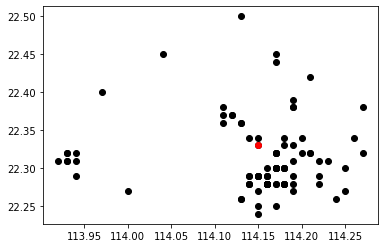

In [32]:
plt.scatter(y=dtf["y"], x=dtf["x"], color="black")
plt.scatter(y=start[0], x=start[1], color="red")
plt.show()

In [33]:
data = dtf.copy()
color = "base"  #color based on this column
lst_colors = ["black","red"]
popup = "id" #popup based on this column
  
# base map
map_ = folium.Map(location=start, tiles="cartodbpositron", zoom_start=11)

# add colors
lst_elements = sorted(list(data[color].unique()))
data["color"] = data[color].apply(lambda x: 
                  lst_colors[lst_elements.index(x)])

# add popup
data.apply(lambda row: 
    folium.CircleMarker(
            location=[row["y"],row["x"]], popup=row[popup],
            color=row["color"], fill=True, radius=5).add_to(map_), 
    axis=1)

# add full-screen button
plugins.Fullscreen(position="topright", title="Expand", 
      title_cancel="Exit", force_separate_button=True).add_to(map_)

# show
map_

In [34]:
# add lines
for i in range(len(dtf)):
    points = [start, dtf[["y","x"]].iloc[i].tolist()]
    folium.PolyLine(points, tooltip="Coast", color="red", 
                    weight=0.5, opacity=0.5).add_to(map_)

map_


In [35]:
layers = ["cartodbpositron", "openstreetmap", "Stamen Terrain", 
          "Stamen Water Color", "Stamen Toner", "cartodbdark_matter"]
for tile in layers:
    folium.TileLayer(tile).add_to(map_)
folium.LayerControl(position='bottomright').add_to(map_)
map_

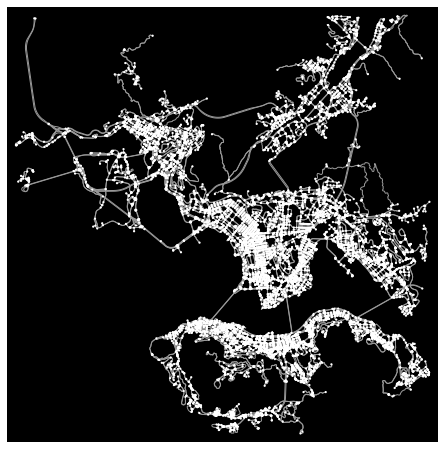

In [36]:
# create network graph
G = ox.graph_from_point(start, dist=10000, 
        network_type="drive")  #'drive', 'bike', 'walk'
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

# plot
fig, ax = ox.plot_graph(G, bgcolor="black", node_size=5, 
        node_color="white", figsize=(16,8))

In [37]:
G.nodes()

NodeView((24533064, 26411640, 26411641, 26412251, 30747332, 30747334, 32899260, 33004487, 33004488, 33004530, 33004534, 33004677, 33476495, 33476497, 33476500, 33476501, 33476508, 33476510, 33476549, 33476552, 50060656, 50060666, 50060672, 165996965, 165997625, 165997863, 165997979, 165998789, 165999009, 165999248, 166091633, 166091692, 232200869, 232216516, 232216519, 232216520, 232216521, 232221477, 232221479, 232221524, 232221586, 232221594, 232230172, 235148491, 235220025, 236675147, 236675154, 237489631, 237492204, 237492208, 237492225, 239978227, 239978228, 239978277, 239978278, 239989632, 239989634, 239989636, 239990432, 239990433, 239990443, 239990446, 239990447, 239990448, 239990457, 239990812, 239991573, 239994475, 239994496, 239994930, 239994932, 240004295, 241833128, 243845374, 243846384, 245088222, 245088364, 245088365, 245088408, 245088874, 249968569, 249968570, 249968572, 249968862, 251083363, 251083380, 253020938, 253287504, 253287703, 253290813, 253290814, 253290826, 2

In [38]:
print("nodes:", len(G.nodes()))
ox.graph_to_gdfs(G, nodes=True, edges=False).reset_index().head(3)

nodes: 9586


,osmid,y,x,street_count,ref,highway,geometry
0,24533064,22.276527,114.173172,3,NaN,NaN,POINT (114.17317 22.27653)
1,26411640,22.250336,114.169964,3,NaN,NaN,POINT (114.16996 22.25034)
2,26411641,22.250545,114.171056,3,NaN,NaN,POINT (114.17106 22.25054)


In [39]:
end = dtf[dtf["id"]==68][["y","x"]].values[0]
print("locations: from", start, "--> to", end)

locations: from [ 22.33 114.15] --> to [ 22.34 114.15]


In [40]:
start_node = ox.distance.nearest_nodes(G, start[1], start[0])
end_node = ox.distance.nearest_nodes(G, end[1], end[0])
print("nodes: from", start_node, "--> to", end_node)

nodes: from 493883072 --> to 480679404


[493883072, 289293755, 289294146, 289294087, 275816026, 289329905, 1182677821, 1645492788, 1645492916, 1191992694, 5101419365, 332257610, 999331442, 1191992696, 480679312, 999331647, 1641766800, 480679404]


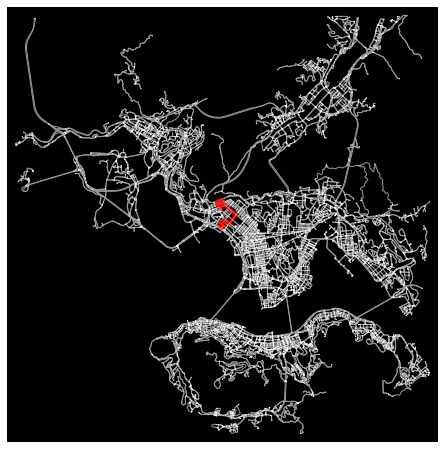

In [41]:
# calculate shortest path
path_lenght = nx.shortest_path(G, source=start_node, target=end_node, 
                                method='dijkstra', weight='lenght')     
print(path_lenght)

# plot on the graph
fig, ax = ox.plot_graph_route(G, path_lenght, route_color="red", 
                              route_linewidth=5, node_size=1, 
                              bgcolor='black', node_color="white", 
                              figsize=(16,8))

[493883072, 289293755, 289294146, 289295423, 289295628, 289295766, 289295767, 289295566, 5101376323, 4844635141, 289295620, 274244744, 1641766635, 1641766639, 1641766654, 999331442, 1191992696, 480679312, 999331647, 1641766800, 480679404]


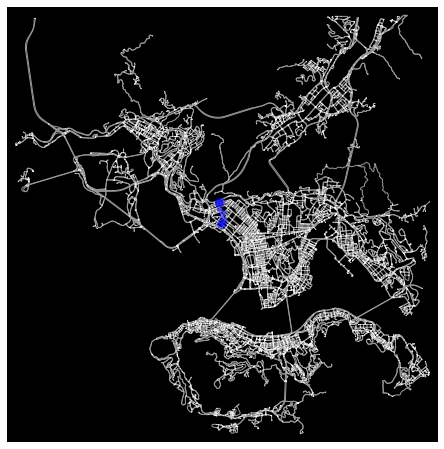

In [42]:
# calculate shortest path
path_time = nx.shortest_path(G, source=start_node, target=end_node, 
                              method='dijkstra', weight='travel_time')   
print(path_time)

# plot on the graph
fig, ax = ox.plot_graph_route(G, path_time, route_color="blue", 
                              route_linewidth=5, node_size=1, 
                              bgcolor='black', node_color="white", 
                              figsize=(16,8))


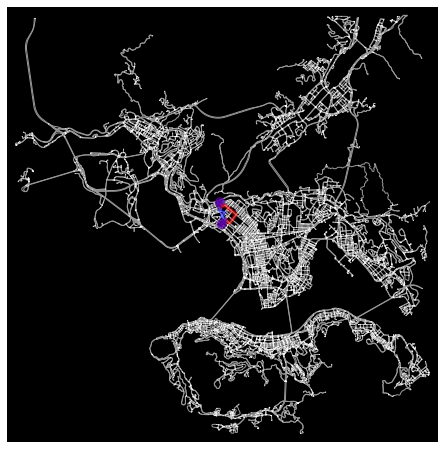

In [43]:
# plot on the graph
fig, ax = ox.plot_graph_routes(G, routes=[path_lenght, path_time], 
                              route_colors=["red","blue"], 
                              route_linewidth=5, node_size=1, 
                              bgcolor='black', node_color="white", 
                              figsize=(16,8))

In [44]:
# plot on the map
ox.plot_route_folium(G, route=path_lenght, route_map=map_, 
                     color="red", weight=1)
ox.plot_route_folium(G, route=path_time, route_map=map_, 
                     color="blue", weight=1)
map_

/var/folders/80/bnhtmcbx6w3b8w1gx2g442000000gn/T/ipykernel_96136/3413822131.py:2: UserWarning: The `folium` module has been deprecated and will be removed in a future release. You can generate and explore interactive web maps of graph nodes, edges, and/or routes automatically using GeoPandas.GeoDataFrame.explore instead, for example like: `ox.graph_to_gdfs(G, nodes=False).explore()`. See the OSMnx examples gallery for complete details and demonstrations.
  ox.plot_route_folium(G, route=path_lenght, route_map=map_,
/var/folders/80/bnhtmcbx6w3b8w1gx2g442000000gn/T/ipykernel_96136/3413822131.py:4: UserWarning: The `folium` module has been deprecated and will be removed in a future release. You can generate and explore interactive web maps of graph nodes, edges, and/or routes automatically using GeoPandas.GeoDataFrame.explore instead, for example like: `ox.graph_to_gdfs(G, nodes=False).explore()`. See the OSMnx examples gallery for complete details and demonstrations.
  ox.plot_route_foliu